## Objective:
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b> using pyspark ml library.
- <b>Stoke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.
- It is required to obtain <b>ROC > 0.65</b>.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

### Create a spark session and import the required libraries

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import *

# Build our spark session
spark = SparkSession.builder.getOrCreate()

### Create a data schema programatically

In [2]:
schema = StructType([
                    StructField("id", IntegerType(), False),
                    StructField("gender", StringType(), False),
                    StructField("age", DoubleType(), False),
                    StructField('hypertension', IntegerType(), False),
                    StructField('heart_disease', IntegerType(), False),
                    StructField('ever_married', StringType(), False),
                    StructField('work_type', StringType(), False),
                    StructField('Residence_type', StringType(), False),
                    StructField('avg_glucose_level', DoubleType(), False),
                    StructField('bmi', DoubleType(), False),
                    StructField('smoking_status', StringType(), False),
                    StructField('stroke', IntegerType(), False),
                    ])

### Read the data using the standard DataReader (Key,Value) pairs format
- Provide the schema and any other required options.

In [3]:
df = spark.read.option('header', True).schema(schema).csv('healthcare-dataset-stroke-data.csv')

### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 5 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [4]:
# Print the Schema.
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [5]:
# Show the first 5 rows from the data.
df.show(5, truncate=True)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [6]:
# Explore null values and show how many null values in each column.
from pyspark.sql.functions import *
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show(truncate=False)

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|id |gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|0  |0     |0  |0           |0            |0           |0        |0             |0                |201|0             |0     |
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [7]:
# Plot a count plot for the target label and notice the graph
count = df.groupBy('stroke').agg(count('stroke'))
count_ = count.toPandas()

In [8]:
count_

,stroke,count(stroke)
0,1,249
1,0,4861


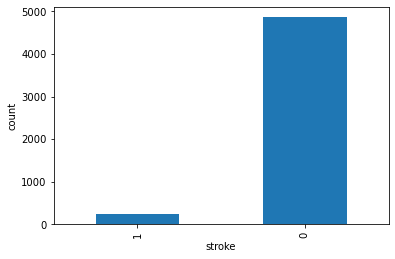

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# As you notice in the below bar chart that the classes are unbalanced.
count_['count(stroke)'].plot.bar()
plt.xlabel('stroke')
plt.ylabel('count')
plt.xticks(np.arange(2) ,[1, 0])
plt.show()

In [10]:
# Perform any additional EDA you find useful.
df_pd = df.toPandas()
df_pd.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


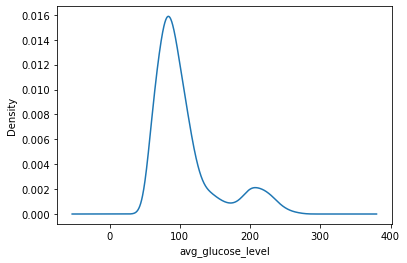

In [11]:
df_pd['avg_glucose_level'].plot.kde()
plt.xlabel('avg_glucose_level')
plt.show()

### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [12]:
# You will find the minimum age is about 0.08.
df.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+



In [13]:
# Remove rows for the age below 2 years old.
df_updated = df.select('*').where(col('age') >= 2)

In [14]:
df_updated.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              4990|
|   mean| 44.23907815631262|
| stddev|21.908077881917443|
|    min|               2.0|
|    max|              82.0|
+-------+------------------+



### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [15]:
# Select and show the gender & smoking_status columns
df_updated.select('gender', 'smoking_status').show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [16]:
# Get the distinct values for gender column
df_updated.select('gender').distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [17]:
# Get the distinct values for smoking_status column
df_updated.select('smoking_status').distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [18]:
# Applying user defined function(UDF).
def gender_mapping(col):
    if col == 'Male':
        return 1
    else:
        return 0
        
gender_mapper = udf(gender_mapping, IntegerType())
df = df.withColumn('gender', gender_mapper('gender'))

In [19]:
df.select('gender').show(5)

+------+
|gender|
+------+
|     1|
|     0|
|     1|
|     0|
|     0|
+------+
only showing top 5 rows



In [20]:
# Make UDF function to map the smoking_status column.
def map_ss(col):
    if col == 'never smoked':
        return 0.0
    elif col == 'Unknown':
        return 0.5
    elif col == 'formerly smoked':
        return 0.75
    else:
        return 1.0
    
smoking_status_mapper = udf(map_ss, DoubleType())
df = df.withColumn('smoking_status', smoking_status_mapper('smoking_status'))

In [21]:
df.select('smoking_status').show(5)

+--------------+
|smoking_status|
+--------------+
|          0.75|
|           0.0|
|           0.0|
|           1.0|
|           0.0|
+--------------+
only showing top 5 rows



#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [22]:
df.select('gender', 'smoking_status').show(5)

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
+------+--------------+
only showing top 5 rows



### Deal with null value according to your data analysis.

In [23]:
# Previously we found 201 null values in the bmi column 
# Null values are very small compared with the whole data frame, so it will not affect the data frame when we drop them.

null_ration = 201/df.count()
print(null_ration)

0.03933463796477495


In [24]:
df = df.dropna()
df.count()

4909

### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [25]:
trainDF, testDF = df.randomSplit([.8,.2],seed=42)

In [26]:
trainDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)



In [27]:
# Save each dataframe as a parquet file.
trainDF.write.parquet('train.parquet')
testDF.write.parquet('test.parquet')

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [28]:
train = spark.read.parquet('train.parquet')
test = spark.read.parquet('test.parquet')

In [29]:
# Don't forget that we still have the label 'stroke'.
train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)



### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [30]:
# Perform feature engineering steps
from pyspark.ml.feature import StringIndexer,\
                               OneHotEncoder,\
                               VectorAssembler

In [31]:
# Get all categorical columns.
cat_cols = [col for (col, type) in train.dtypes if type == 'string']

# Get all neumerical columns.
num_cols = [col for (col, type) in train.dtypes if (type in ['int', 'double']) & (col !='stroke')]

In [32]:
# 1) Prepare StringIndexer.
index_Out_cols = [x + "_Index" for x in cat_cols]
index_Out_cols

['ever_married_Index', 'work_type_Index', 'Residence_type_Index']

In [33]:
# 2) Prepare OneHotEncoder.
ohe_out_cols = [x + "_OHE" for x in cat_cols]
ohe_out_cols

['ever_married_OHE', 'work_type_OHE', 'Residence_type_OHE']

In [34]:
# Apply StringIndexer & OneHotEncoder 
StringIndexer = StringIndexer(inputCols=cat_cols, outputCols=index_Out_cols)
OneHotEncoder = OneHotEncoder(inputCols=index_Out_cols, outputCols=ohe_out_cols)

In [35]:
# Apply VectorAssembler.
all_cols = ohe_out_cols + num_cols
vecAssemb = VectorAssembler(inputCols = all_cols, outputCol='features')

In [36]:
# Create the logistic regression classifier.
from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(featuresCol='features',labelCol='stroke')

In [37]:
# Build the pipeline model that uses all feature engineering steps and the model.
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[StringIndexer,
                            OneHotEncoder,
                            vecAssemb,
                            log_reg])

In [38]:
# Train the pipeline model using the trainig dataset.
model = pipeline.fit(train)

### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [39]:
# Test the model using the test dataframe.
predictions = model.transform(test)

In [40]:
# Select and show the feature column.
predictions.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|(14,[1,5,6,8,11,1...|
|(14,[1,6,8,11,12,...|
|(14,[0,1,6,8,11,1...|
|(14,[0,1,5,6,7,8,...|
|(14,[0,1,5,6,8,11...|
+--------------------+
only showing top 5 rows



In [41]:
# Print the schema of the output dataframe.
predictions.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- ever_married_Index: double (nullable = false)
 |-- work_type_Index: double (nullable = false)
 |-- Residence_type_Index: double (nullable = false)
 |-- ever_married_OHE: vector (nullable = true)
 |-- work_type_OHE: vector (nullable = true)
 |-- Residence_type_OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [42]:
# Select and show both prediction and label columns.
predictions.select('prediction', 'stroke').show()

+----------+------+
|prediction|stroke|
+----------+------+
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     1|
|       0.0|     0|
+----------+------+
only showing top 20 rows



In [43]:
# Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.notice the result.
predictions.select('stroke', 'prediction').where((col('stroke') == 1)).show()

+------+----------+
|stroke|prediction|
+------+----------+
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
+------+----------+
only showing top 20 rows



In [44]:
print(predictions.select('stroke').where(col('stroke') == 0.0).count())
print(predictions.select('stroke').where(col('stroke') == 1.0).count())

899
38


In [45]:
# Count the predicted 1 and 0 values.notice the result.
# df.groupBy('stroke').agg(count('stroke'))
print(predictions.select('prediction').where(col('prediction') == 0.0).count())
print(predictions.select('prediction').where(col('prediction') == 1.0).count())

937
0


### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [46]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [47]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [48]:
evaluatorROC.evaluate(predictions)

0.5

### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.

In [49]:
weigh_0 = train.filter('stroke = 0').select('stroke').count() / (train.count())
weigh_1 = train.filter('stroke = 1').select('stroke').count() / (train.count())

In [50]:
def weight_col(col):
    if col == 0:
        return weigh_1
    else:
        return weigh_0
    
weigh_converter = udf(weight_col, DoubleType())
train = train.withColumn('stroke_weighted', weigh_converter('stroke'))

In [51]:
new_log_reg = LogisticRegression(featuresCol='features',labelCol='stroke', weightCol='stroke_weighted')

In [52]:
new_pipeline = Pipeline(stages=[StringIndexer,
                                OneHotEncoder,
                                vecAssemb,
                                new_log_reg])

In [53]:
new_model = new_pipeline.fit(train)
new_predictions = new_model.transform(test)

In [54]:
print(new_predictions.select('prediction').where(col('prediction') == 0.0).count())
print(new_predictions.select('prediction').where(col('prediction') == 1.0).count())

657
280


In [55]:
evaluatorROC.evaluate(new_predictions)

0.796835665359171